In [16]:
import evaluate
from evaluate import load
rouge = evaluate.load('rouge')
meteor = evaluate.load('meteor')
import os
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict

[nltk_data] Downloading package wordnet to /Users/geemi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/geemi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/geemi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
tasks = ['OMS','PLD','TOX','SOL','UFL']

In [22]:
file_prefix = "structure_function_relationship"
base = '/Users/geemi/Geemi_docs/LIAC/revisions_xpertai/xprtai_2'
for task in tasks:
     for i in range(1,6):
          filename = f"data_rd3/{task}/{file_prefix}_{i}.md" 
          new_filename = f"{base}/open_source/multi_data/{task}/query_{i}/xpertai_explanation_{i}.txt"
          #copy file
          os.system(f"cp {filename} {new_filename}")
     # copy each file into new directory
     # 

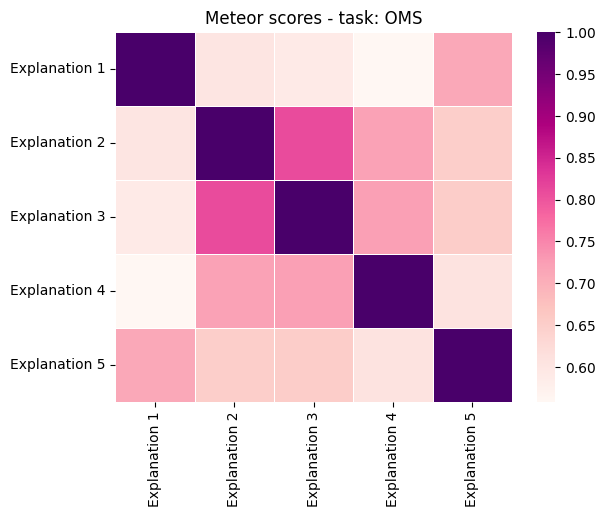

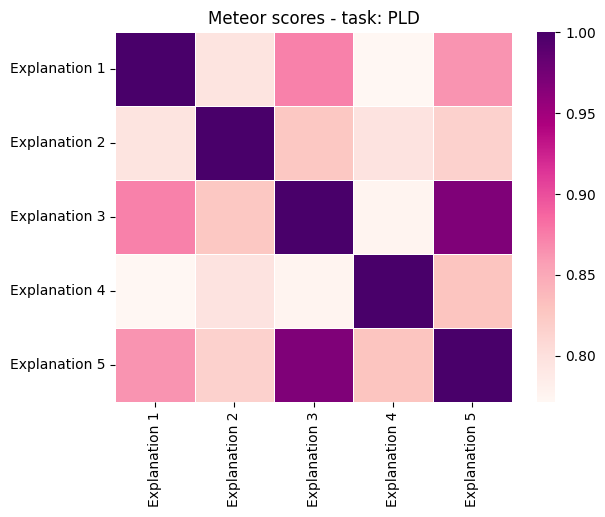

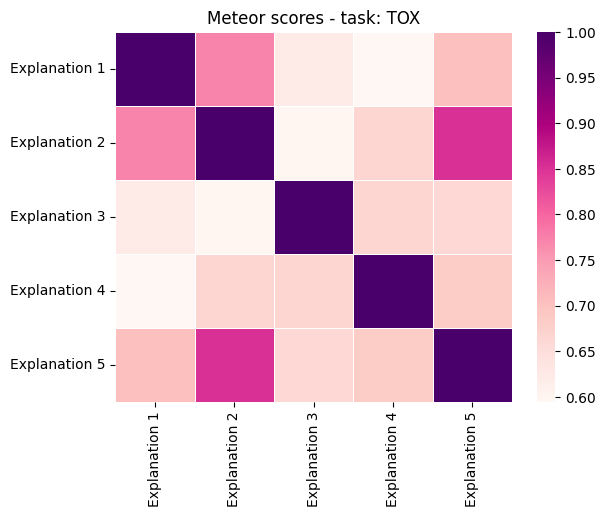

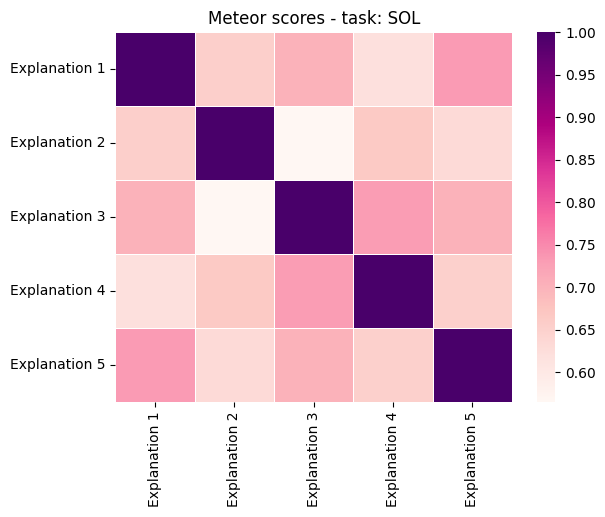

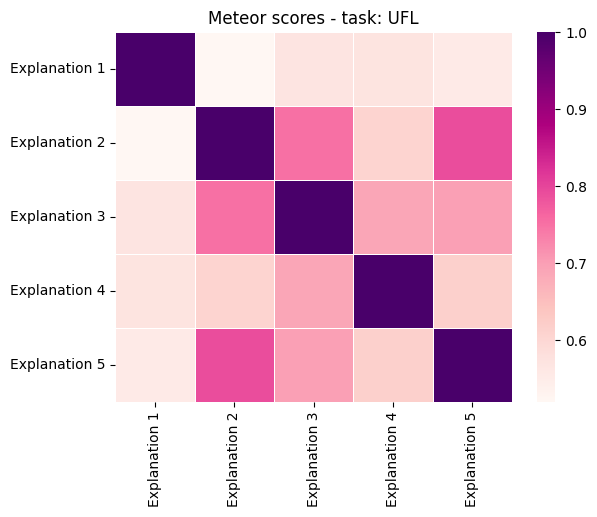

In [10]:
explanations = ["chatgpt"] #["xpertai", "baseline","chatgpt"]
for explanation in explanations: 
    if explanation == "xpertai":
        file_prefix = "structure_function_relationship"
    else:
        file_prefix = f"structure_function_relationship_{explanation}"
    
    for task in tasks:
        filenames = [f"data_rd3/{task}/{file_prefix}_{i}.md" for i in range(1,6)]
        pairs = list(itertools.product(filenames, filenames))
        combs = list(itertools.combinations(filenames,2))

        rouge_results = {}
        meteor_results = {}
        for i in range(len(combs)):    
            f1 = open(combs[i][0]).read()
            f2 = open(combs[i][1]).read()
            ref_int = combs[i][0].split('/')[-1][-4]
            cand_int = combs[i][1].split('/')[-1][-4]
            results = meteor.compute(predictions=[f2], references=[f1]) #rouge.compute(predictions=[f2], references=[f1])
            #results= rouge.compute(predictions=[f2], references=[f1])
            rouge_results[f"{ref_int}_{cand_int}"] = results

        ## create a df and get the transpose for easy use
        df = pd.DataFrame(rouge_results)
        df = df.T

        ## convert ROUGEL data into a matrix
        matrix = np.empty((5,5))
        for row in range(5):
            for col in range(5):
                if col == row:
                    matrix[row][col]=1.0
                else:
                    try:
                        matrix[row][col] = df.loc[f'{row+1}_{col+1}'].meteor #df.loc[f'{row+1}_{col+1}'].rougeL
                        matrix[col][row] = matrix[row][col] 
                    except:
                        continue
        np.save(f'data_rd3/computed_results/{task}/{task}_{explanation}_meteor.npy',matrix)
        ## Create heatmaps and save figs
        xlabels = [f"Explanation {i}" for i in range(1,6)]
        ax = sns.heatmap(matrix, linewidth=0.5,cmap='RdPu', xticklabels=xlabels,yticklabels=xlabels)
        plt.title(f'Meteor scores - task: {task}')

        plt.savefig(f'data_rd3/computed_results/{task}/{task}_{explanation}_meteor.png',bbox_inches='tight',dpi=300)
        plt.show()

## plot bar for avg values across all tasks

In [4]:
data = {}
tasks = ['OMS','PLD','TOX','SOL','UFL']
for task in tasks:
    matrix = np.load(f'data_rd3/computed_results/{task}/{task}_xpertai_rougeL.npy')
    triu = np.triu(matrix,k=1)
    avg = np.mean(triu[np.nonzero(triu)])
    minv = np.min(triu[np.nonzero(triu)])
    maxv = np.max(triu)
    data[task] = [avg,minv,maxv]

In [5]:
hts = [vals[0] for vals in data.values()]
los = [vals[1] for vals in data.values()]
his = [vals[2] for vals in data.values()]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (6,).

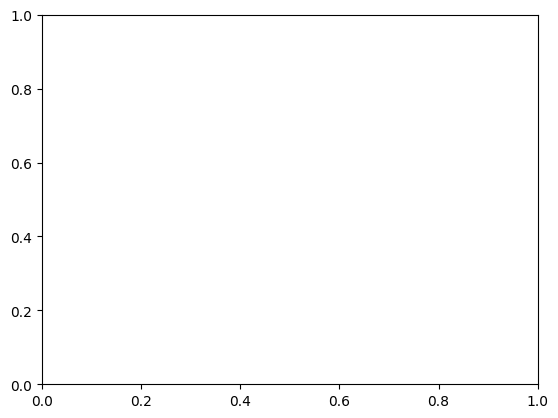

In [7]:
liac = ['#febc2b','#f48849','#db5b68','#b93389','#8b0aa5']
ax = plt.bar(np.arange(5), hts)
plt.xticks(np.arange(5),tasks)
for i, p in enumerate(ax.patches):
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()
    p.set_color(c=liac[i])
    min_y = los[i]
    max_y = his[i]
    plt.vlines(x+w/2, min_y, max_y, color='k')
    plt.hlines(min_y,x+w/2-w/8,x+w/2+w/8,color='k')
    plt.hlines(max_y,x+w/2-w/8,x+w/2+w/8,color='k')

plt.xlabel('Task')
plt.ylabel('RougeL score')
plt.title('Mean RougeL scores: XpertAI explanations',fontsize='medium')
plt.savefig(f'data_rd3/computed_results/xpertai_average_rougeL.png',bbox_inches='tight')
plt.show()

## side by side - mean rougeL scores

In [13]:
### Variances
data = {}

tasks = ['OMS','PLD','TOX','SOL','UFL']
for task in tasks:
    matrix = np.load(f'multi_data_old/{task}/gpt4_rougeL.npy')
    triu = np.triu(matrix,k=1)
    avg = np.mean(triu[np.nonzero(triu)])
    stdev = np.std(triu[np.nonzero(triu)])
    minv = avg - stdev
    maxv = avg + stdev
    data[task] = [avg,minv,maxv]

print(data)

FileNotFoundError: [Errno 2] No such file or directory: 'multi_data_old/OMS/gpt4_rougeL.npy'

In [11]:
metric = 'meteor'
normalize_by_npapers = False
lit_path = "/Users/geemi/Geemi_docs/LIAC/revisions_xpertai/xprtai_2/literature"

def get_data(explanation):
    data = {}
    tasks = ['OMS','PLD','TOX','SOL','UFL']
    for task in tasks:
        matrix = np.load(f'data_rd3/computed_results/{task}/{task}_{explanation}_{metric}.npy') 
        
        triu = np.triu(matrix,k=1)
        if normalize_by_npapers:
            upper_triu = triu[np.nonzero(triu)]
            lit_files = f"{lit_path}/{task}"
            npapers = len(os.listdir(lit_files))
            upper_triu = upper_triu/npapers
        else: 
            upper_triu = triu[np.nonzero(triu)]

        avg = np.mean(upper_triu)
        ## use stdev as a measure of variance
        stdev = np.std(upper_triu)/2
        print(f'{task} avg: {avg} stdev: {stdev}')
        minv = avg - stdev
        maxv = avg + stdev
        data[task] = [avg,minv,maxv]
        #minv = np.min(triu[np.nonzero(triu)])
        #maxv = np.max(triu)
        

    hts = [vals[0] for vals in data.values()]
    los = [vals[1] for vals in data.values()]
    his = [vals[2] for vals in data.values()]
    ## Add the 6th bar for the average of the averages
    sixth = np.mean(hts)
    hts.append(sixth)
    stdev = np.std(hts)/2
    los.append(sixth-stdev)
    his.append(sixth+stdev)
    print(f'6th avg: {sixth} stdev: {stdev}')

    return hts,los,his

OMS avg: 0.6151876945158865 stdev: 0.036416030349791365
PLD avg: 0.6603499383620474 stdev: 0.029577139721738536
TOX avg: 0.5153554862671366 stdev: 0.03538403783060692
SOL avg: 0.4877212220285746 stdev: 0.030246891029056193
UFL avg: 0.5694690550015962 stdev: 0.0435536175688523
6th avg: 0.5696166792350482 stdev: 0.028838925164759353
OMS avg: 0.6626575554382919 stdev: 0.036731864179766746
PLD avg: 0.8314543239454671 stdev: 0.02785105342428191
TOX avg: 0.6819566373626574 stdev: 0.03756020490186867
SOL avg: 0.6656339731736866 stdev: 0.024985482299801225
UFL avg: 0.6372560740922072 stdev: 0.042992340435403925
6th avg: 0.695791712802462 stdev: 0.03164222917869633


/var/folders/3j/w7mmc2y12pddlxs19kfr_6lc0000gn/T/ipykernel_51567/2547059340.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


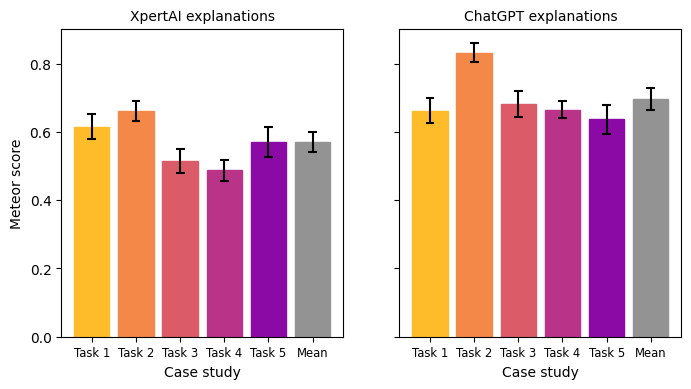

In [14]:
metric = 'meteor'
liac = ['#febc2b','#f48849','#db5b68','#b93389','#8b0aa5','#939393']
labels = ['Task 1','Task 2','Task 3','Task 4','Task 5','Mean']
exp_types = ["xpertai", "chatgpt"]
titles = ['XpertAI explanations','ChatGPT explanations']
fig, axes = plt.subplots(1, 2, sharey=True,figsize=(8,4))
axs = axes.ravel()
num_bars = len(labels)
for n,exp_type in enumerate(exp_types):
    hts, los,his = get_data(exp_type)
    title = titles[n]

    axs[n].bar(np.arange(num_bars), hts)
    #axs[n].scatter(np.arange(5), hts,color='k',marker='o')
    #axs[n].plot(np.arange(5), hts,color='k',ls='--')
    axs[n].set_xticks(np.arange(num_bars),labels,fontsize='small')

    for i, p in enumerate(axs[n].patches):
        x = p.get_x()  # get the bottom left x corner of the bar
        w = p.get_width()  # get width of bar
        h = p.get_height()
        p.set_color(c=liac[i])
        min_y = los[i]
        max_y = his[i]
        axs[n].vlines(x+w/2, min_y, max_y, color='k')
        axs[n].hlines(min_y,x+w/2-w/8,x+w/2+w/8,color='k')
        axs[n].hlines(max_y,x+w/2-w/8,x+w/2+w/8,color='k')

    axs[n].set_xlabel('Case study')
    
    axs[n].set_title(f'{title}',fontsize='medium')
    
axs[0].set_ylabel(f'{metric.capitalize()} score')
fig.savefig(f'data_rd3/computed_results/xpertai_vs_baseline_average_{metric}.png',facecolor='white',bbox_inches='tight',dpi=300)
fig.show()

Variance: 0.009559062581815839


Variance: 0.025919624207030322

In [23]:
means_xprt = [0.5329331251334953, 0.6042416845681611, 0.48353533661908343, 0.42682480914369947, 0.6363940880505758]
means_baseline = [ 0.5202397292395714, 0.5721499581623467, 0.5117359448880502, 0.6309480508180058, 0.6024299120140478]

#run t-test
from scipy.stats import ttest_ind
t, p = ttest_ind(means_xprt,means_baseline)
print(f't: {t} p: {p}')

t: -0.6865958566939655 p: 0.5117438704364834


OMS avg: 0.5329331251334953 stdev: 0.028494570005308716
PLD avg: 0.6042416845681611 stdev: 0.031440466713794815
TOX avg: 0.48353533661908343 stdev: 0.027948360187112088
SOL avg: 0.42682480914369947 stdev: 0.06732416663244883
UFL avg: 0.6363940880505758 stdev: 0.0480603556781434
6th avg: 0.5367858087030031 stdev: 0.035008321555529194
OMS avg: 0.5202397292395714 stdev: 0.03490716683400255
PLD avg: 0.5721499581623467 stdev: 0.015994736748874163
TOX avg: 0.5117359448880502 stdev: 0.027570596755385632
SOL avg: 0.6309480508180058 stdev: 0.01546748797496361
UFL avg: 0.6024299120140478 stdev: 0.0263195582727052
6th avg: 0.5675007190244044 stdev: 0.021026311937979793


/var/folders/3j/w7mmc2y12pddlxs19kfr_6lc0000gn/T/ipykernel_47693/1208629249.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


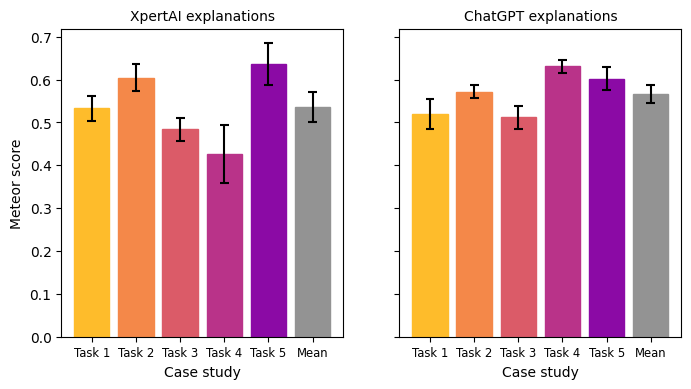

In [ ]:
metric = 'meteor'
liac = ['#febc2b','#f48849','#db5b68','#b93389','#8b0aa5','#939393']
labels = ['Task 1','Task 2','Task 3','Task 4','Task 5','Mean']
exp_types = ["xpertai", "baseline"]
titles = ['XpertAI explanations','ChatGPT explanations']
fig, axes = plt.subplots(1, 2, sharey=True,figsize=(8,4))
axs = axes.ravel()
num_bars = len(labels)
for n,exp_type in enumerate(exp_types):
    hts, los,his = get_data(exp_type)
    title = titles[n]

    axs[n].bar(np.arange(num_bars), hts)
    #axs[n].scatter(np.arange(5), hts,color='k',marker='o')
    #axs[n].plot(np.arange(5), hts,color='k',ls='--')
    axs[n].set_xticks(np.arange(num_bars),labels,fontsize='small')

    for i, p in enumerate(axs[n].patches):
        x = p.get_x()  # get the bottom left x corner of the bar
        w = p.get_width()  # get width of bar
        h = p.get_height()
        p.set_color(c=liac[i])
        min_y = los[i]
        max_y = his[i]
        axs[n].vlines(x+w/2, min_y, max_y, color='k')
        axs[n].hlines(min_y,x+w/2-w/8,x+w/2+w/8,color='k')
        axs[n].hlines(max_y,x+w/2-w/8,x+w/2+w/8,color='k')

    axs[n].set_xlabel('Case study')
    
    axs[n].set_title(f'{title}',fontsize='medium')
    
axs[0].set_ylabel(f'{metric.capitalize()} score')
fig.savefig(f'data_rd3/computed_results/xpertai_vs_baseline_average_{metric}.png',facecolor='white',bbox_inches='tight',dpi=300)
fig.show()

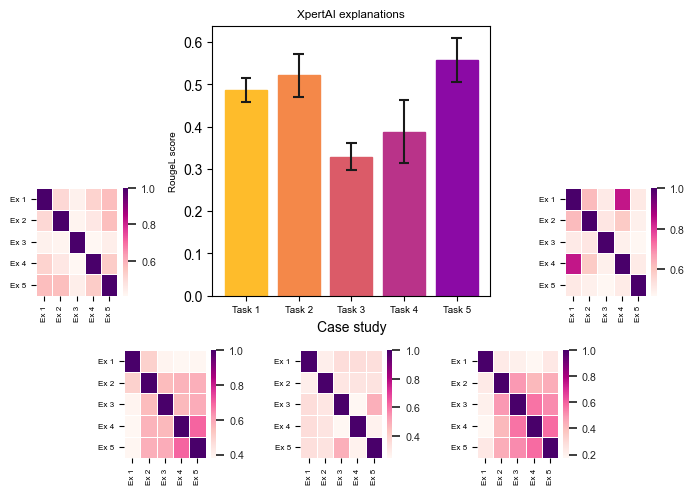

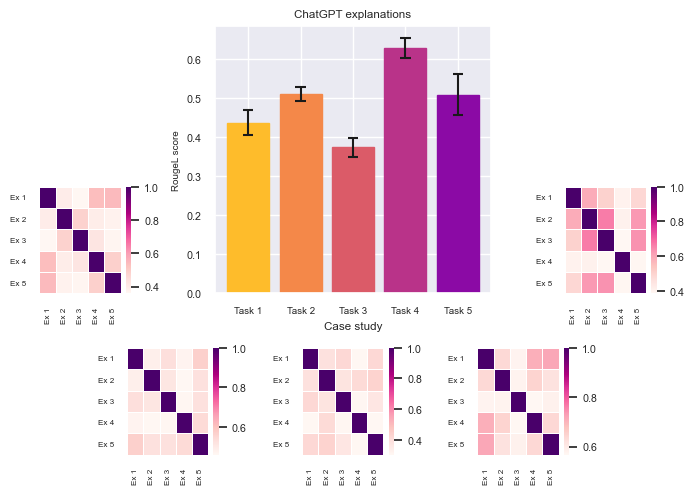

In [24]:
explanations = ["xpertai", "baseline"]
for explanation in explanations:
    axd = plt.figure(layout="tight",figsize=(7,5)).subplot_mosaic(
    """
    xxFFFFxx
    DDFFFFEE
    xAABBCCx
    """,
empty_sentinel="x"
 
    )
    sns.set_theme(font_scale=0.7)
    tasks = ['OMS','PLD','TOX','SOL','UFL']
    labels = ['Task 1','Task 2','Task 3','Task 4','Task 5']
    ax_labs = ['D','A','B','C','E']
    data = {}
    for d, task in enumerate(tasks):
        matrix =  np.load(f'data_rd3/computed_results/{task}/{task}_{explanation}_rougeL.npy') 
        triu = np.triu(matrix,k=1)
        avg = np.mean(triu[np.nonzero(triu)])
        ## use stdev as a measure of variance
        stdev = np.std(triu[np.nonzero(triu)])/2
        minv = avg - stdev
        maxv = avg + stdev
        #minv = np.min(triu[np.nonzero(triu)])
        #maxv = np.max(triu)
        data[task] = [avg,minv,maxv]
        
        xlabels = [f"Ex {i}" for i in range(1,6)]
        g = sns.heatmap(matrix, linewidth=0.5,cmap='RdPu', ax=axd[ax_labs[d]],
                        xticklabels=xlabels, yticklabels=xlabels)
        #g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 8)

        #axd[ax_labs[d]].set_title(f'Task: {task}',fontsize='xx-small')
        axd[ax_labs[d]].set_xticklabels(xlabels, fontsize='x-small')
        axd[ax_labs[d]].set_yticklabels(xlabels, fontsize='x-small',rotation=0)

        #plt.savefig(f'multi_data/figures/{task}_GPT4_rougeL.png',bbox_inches='tight',dpi=300)
    hts = [vals[0] for vals in data.values()]
    los = [vals[1] for vals in data.values()]
    his = [vals[2] for vals in data.values()]


    liac = ['#febc2b','#f48849','#db5b68','#b93389','#8b0aa5']
    axd['F'].bar(np.arange(5), hts)
    axd['F'].set_xticks(np.arange(5),labels,fontsize='small')
    for i, p in enumerate(axd['F'].patches):
        x = p.get_x()  # get the bottom left x corner of the bar
        w = p.get_width()  # get width of bar
        h = p.get_height()
        p.set_color(c=liac[i])
        min_y = los[i]
        max_y = his[i]
        axd['F'].vlines(x+w/2, min_y, max_y, color='k')
        axd['F'].hlines(min_y,x+w/2-w/8,x+w/2+w/8,color='k')
        axd['F'].hlines(max_y,x+w/2-w/8,x+w/2+w/8,color='k')

    axd['F'].set_xlabel('Case study')
    axd['F'].set_ylabel('RougeL score',fontsize='small')
    if explanation == "xpertai":
        title_prefix = "XpertAI"
    else:
        title_prefix = "ChatGPT"
    axd['F'].set_title(f'{title_prefix} explanations',fontsize='medium')
    plt.savefig(f'data_rd3/computed_results/rougeL_{explanation}_summary.png',bbox_inches='tight')
    plt.show()

In [124]:
print(np.mean(triu[np.nonzero(triu)]))

0.6956405070333269


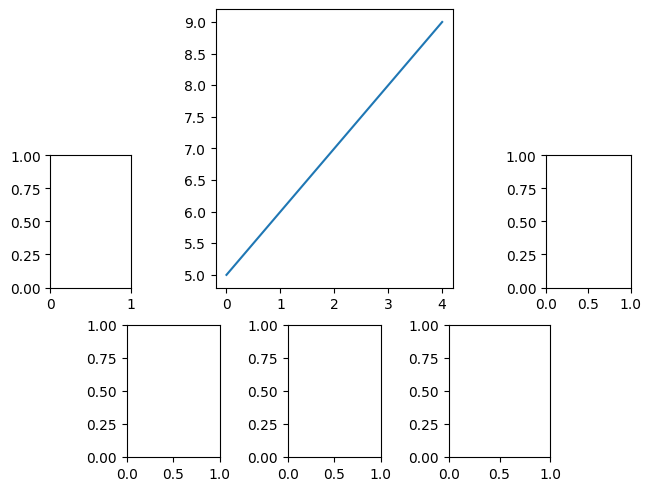

In [21]:
axd = plt.figure(layout="constrained").subplot_mosaic(
    """
    xxFFFFxx
    DDFFFFEE
    xAABBCCx
    """,
empty_sentinel="x"
 
)
axd['F'].plot(np.arange(5),np.arange(5,10))